In [1]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from numpy import asarray
import os
from tqdm import tqdm

In [3]:
dir_path = '../TB_Chest_Radiography_Database/'

In [4]:
working_dir = '../TB_Chest_Radiography_Database/Noise/'

In [5]:
# get the current directory
dir_path = os.getcwd()
print("Current directory is : " + dir_path)

# read X, y, X_test_noise, y_test_noise from file
X = np.load('../2_training_with_noise/X.npy')
y = np.load('../2_training_with_noise/y.npy')
X_test_noise = np.load('../2_training_with_noise/X_test_noise.npy')
y_test_noise = np.load('../2_training_with_noise/y_test_noise.npy')

Current directory is : /Users/adrianmcintosh/Desktop/UCLA/BIOENGR M209/Project_V2/4_changing_cnn_model


In [6]:
X.shape

(6580, 128, 128, 3)

In [7]:
X_test_noise.shape

(700, 128, 128, 3)

In [ ]:
y.shape

In [ ]:
y_test_noise.shape

In [8]:
import pandas as pd

In [56]:
y_df = pd.DataFrame(y)
y_df.value_counts()

1.0    3430
0.0    3150
Name: count, dtype: int64

In [ ]:
y_test_noise_df = pd.DataFrame(y_test_noise)
y_test_noise_df.value_counts()

Estimated Gaussian noise standard deviation = 0.012834868537196393


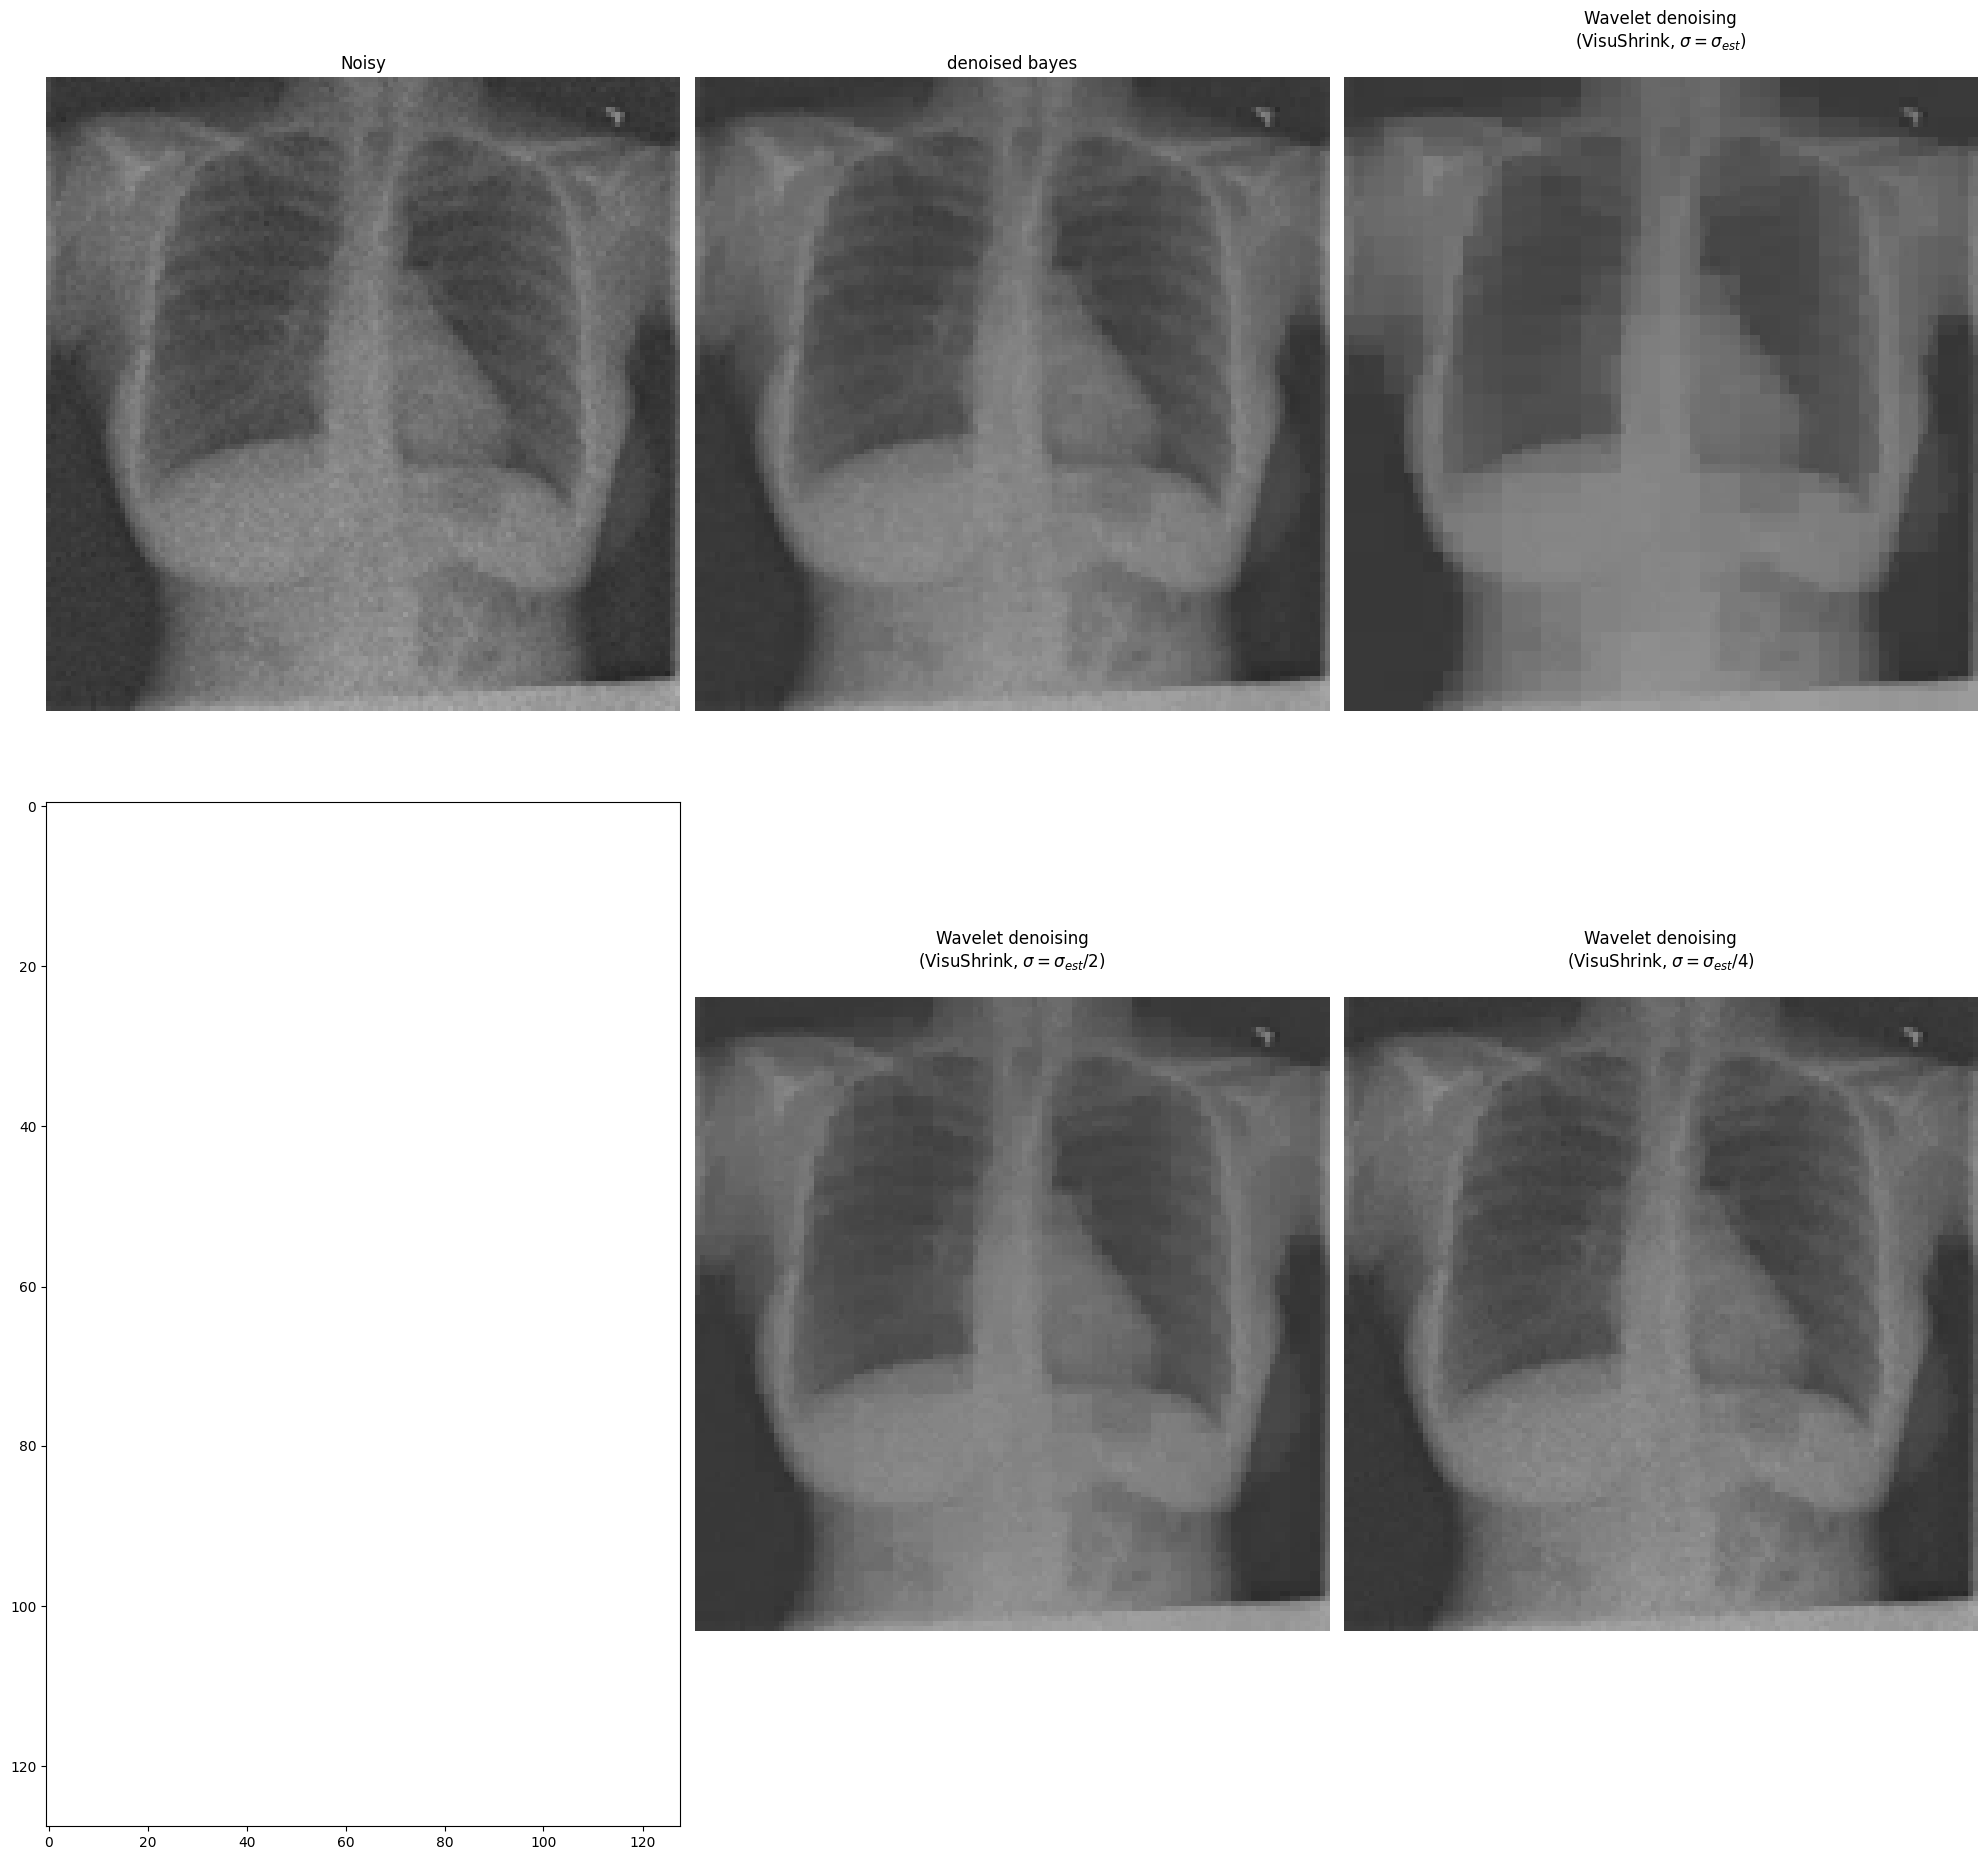

In [7]:
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio



noisy = X[1]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 20),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, channel_axis=-1, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

im_bayes = denoise_wavelet(noisy, channel_axis=-1, convert2ycbcr=True,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)
im_visushrink = denoise_wavelet(noisy, channel_axis=-1, convert2ycbcr=True,
                                method='VisuShrink', mode='soft',
                                sigma=sigma_est, rescale_sigma=True)

# VisuShrink is designed to eliminate noise with high probability, but this
# results in a visually over-smooth appearance.  Repeat, specifying a reduction
# in the threshold by factors of 2 and 4.
im_visushrink2 = denoise_wavelet(noisy, channel_axis=-1, convert2ycbcr=True,
                                 method='VisuShrink', mode='soft',
                                 sigma=sigma_est/2, rescale_sigma=True)
im_visushrink4 = denoise_wavelet(noisy, channel_axis=-1, convert2ycbcr=True,
                                 method='VisuShrink', mode='soft',
                                 sigma=sigma_est/4, rescale_sigma=True)

# Compute PSNR as an indication of image quality
# psnr_noisy = peak_signal_noise_ratio(original, noisy)
# psnr_bayes = peak_signal_noise_ratio(original, im_bayes)
# psnr_visushrink = peak_signal_noise_ratio(original, im_visushrink)
# psnr_visushrink2 = peak_signal_noise_ratio(original, im_visushrink2)
# psnr_visushrink4 = peak_signal_noise_ratio(original, im_visushrink4)

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title(f'Noisy')
ax[0, 1].imshow(im_bayes)
ax[0, 1].axis('off')
ax[0, 1].set_title('denoised bayes')
    # f'Wavelet denoising\n(BayesShrink)\nPSNR={psnr_bayes:0.4g}')
ax[0, 2].imshow(im_visushrink)
ax[0, 2].axis('off')
ax[0, 2].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}$)\n')

ax[1, 1].imshow(im_visushrink2)
ax[1, 1].axis('off')
ax[1, 1].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/2$)\n')
ax[1, 2].imshow(im_visushrink4)
ax[1, 2].axis('off')
ax[1, 2].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/4$)\n')
fig.tight_layout()

plt.show()

In [8]:
# write a function that does wavelet denoising on a single image with sigma_est/4
def wavelet_denoising(img):
    sigma_est = estimate_sigma(img, channel_axis=-1, average_sigmas=True)
    im_visushrink4 = denoise_wavelet(img, channel_axis=-1, convert2ycbcr=True,
                                 method='VisuShrink', mode='soft',
                                 sigma=sigma_est/4, rescale_sigma=True)
    return im_visushrink4

In [9]:
# run the function on all images in X and X_test_noise
X_denoised = []
for i in tqdm(range(len(X))):
    X_denoised.append(wavelet_denoising(X[i]))
X_denoised = np.array(X_denoised)

X_test_noise_denoised = []
for i in tqdm(range(len(X_test_noise))):
    X_test_noise_denoised.append(wavelet_denoising(X_test_noise[i]))
X_test_noise_denoised = np.array(X_test_noise_denoised)

# save the denoised images
np.save('X_denoised.npy', X_denoised)
np.save('X_test_noise_denoised.npy', X_test_noise_denoised)

100%|██████████| 700/700 [00:01<00:00, 557.80it/s]


Balanced dataset!

Table representing the architecture of the CNN model 

| Layer (Type)   | Number of Filters | Padding | Activation | Out of Activation Shape | Total Parameters            |
|-----------------|-------------------|---------|------------|--------------------------|-----------------------------|
| Input           | -                 | -       | -          | (128, 128, 1)            | 0                           |
| Conv2D          | 32 * unit_size_rate| Same    | ReLU       | (128, 128, 32)           | 320 * unit_size_rate        |
| MaxPooling2D    | -                 | Same    | -          | (64, 64, 32)             | 0                           |
| Conv2D          | 64 * unit_size_rate| Same    | ReLU       | (64, 64, 64)             | 18,496 * unit_size_rate     |
| MaxPooling2D    | -                 | Same    | -          | (32, 32, 64)             | 0                           |
| Conv2D          | 128 * unit_size_rate| Same    | ReLU       | (32, 32, 128)            | 73,856 * unit_size_rate     |
| MaxPooling2D    | -                 | Same    | -          | (16, 16, 128)            | 0                           |
| Flatten         | -                 | -       | -          | (32768)                  | 0                           |
| Dense           | 128 * unit_size_rate| -      | ReLU       | (128)                    | 4,194,560 * unit_size_rate |
| Dropout         | -                 | -       | -          | (128)                    | 0                           |
| Dense           | 1                 | -       | Sigmoid    | (1)                      | 129                         |

Total Params: 4,287,361 * unit_size_rate

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, Dense

/Users/adrianmcintosh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [11]:
class CNN:
    def __init__(self, 
                 input_shape=(128, 128, 3), 
                 unit_size_rate=0.05, 
                 conv_padding='same', 
                 conv_kernel_size=(3, 3),
                 conv_stride=1, 
                 pool_padding='same', 
                 pool_kernel_size=(2, 2), 
                 pool_stride=2, 
                 dropout=0, 
                 l1_lambda=None,
                 l2_lambda=None, 
                 pooling_type='max', 
                 epochs=5, 
                 batch_size=64, 
                 verbose=1):
        self.input_shape = input_shape
        self.unit_size_rate = unit_size_rate
        self.conv_padding = conv_padding
        self.conv_kernel_size = conv_kernel_size
        self.conv_stride = conv_stride
        self.pool_padding = pool_padding
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.dropout = dropout
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.pooling_type = pooling_type
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = self.build_model()

    def build_model(self):
        reg_l1 = None
        reg_l2 = None

        if self.l1_lambda is not None:
            reg_l1 = tf.keras.regularizers.l1(self.l1_lambda)

        if self.l2_lambda is not None:
            reg_l2 = tf.keras.regularizers.l2(self.l2_lambda)

        if len(self.input_shape) == 2:
            # Add color channel for grayscale images
            self.input_shape = self.input_shape + (1,)

        model = Sequential()
        model.add(Conv2D(
            int(32 * self.unit_size_rate),
            self.conv_kernel_size,
            strides=self.conv_stride,
            padding=self.conv_padding,
            activation='relu',
            kernel_regularizer=reg_l1,
            input_shape=self.input_shape))

        if self.pooling_type == 'max':
            model.add(MaxPooling2D(
                pool_size=self.pool_kernel_size,
                strides=self.pool_stride,
                padding=self.pool_padding))
        elif self.pooling_type == 'avg':
            model.add(AveragePooling2D(
                pool_size=self.pool_kernel_size,
                strides=self.pool_stride,
                padding=self.pool_padding))
        else:
            raise ValueError("Invalid pooling_type. Use 'max' or 'avg'.")

        model.add(Conv2D(
            int(64 * self.unit_size_rate),
            self.conv_kernel_size,
            strides=self.conv_stride,
            padding=self.conv_padding,
            kernel_regularizer=reg_l2,
            activation='relu'))

        if self.pooling_type == 'max':
            model.add(MaxPooling2D(
                pool_size=self.pool_kernel_size,
                strides=self.pool_stride,
                padding=self.pool_padding))
        elif self.pooling_type == 'avg':
            model.add(AveragePooling2D(
                pool_size=self.pool_kernel_size,
                strides=self.pool_stride,
                padding=self.pool_padding))
        else:
            raise ValueError("Invalid pooling_type. Use 'max' or 'avg'.")

        model.add(Conv2D(
            int(128 * self.unit_size_rate),
            self.conv_kernel_size,
            strides=self.conv_stride,
            padding=self.conv_padding,
            kernel_regularizer=reg_l2,
            activation='relu'))

        if self.pooling_type == 'max':
            model.add(MaxPooling2D(
                pool_size=self.pool_kernel_size,
                strides=self.pool_stride,
                padding=self.pool_padding))
        elif self.pooling_type == 'avg':
            model.add(AveragePooling2D(
                pool_size=self.pool_kernel_size,
                strides=self.pool_stride,
                padding=self.pool_padding))
        else:
            raise ValueError("Invalid pooling_type. Use 'max' or 'avg'.")

        model.add(Flatten())
        model.add(Dense(
            units=int(128 * self.unit_size_rate),
            activation='relu',
            kernel_regularizer=reg_l2))

        model.add(Dropout(self.dropout))
        model.add(Dense(units=1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def predict(self, X, threshold=0.5, verbose=0):
        return (self.model.predict(X, verbose=verbose) > threshold).astype("int32")

    def summary(self):
        self.model.summary()

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, verbose=1):
        history = self.model.fit(
            X_train, y_train,
            batch_size=batch_size if batch_size else self.batch_size,
            epochs=epochs if epochs else self.epochs,
            verbose=verbose,
            validation_data=(X_val, y_val)
        )
        return history

In [12]:
cnn = CNN(unit_size_rate=1,
          input_shape=(128,128,3))

In [13]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 128)       0

# 3. Splitting the Dataset:
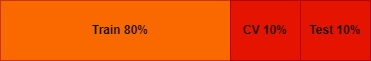

Split the dataset into training, validation, and test sets. The usual split ratios are 
- 80% for training, 
- 10% for validation, 
- and 10% for testing. 
Ensure that the classes are balanced in each split.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
def viz_class_distribution(X, y, title, classe_labels, train_percent=0.6, val_percent=0.2, test_percent=0.2):
    '''
    :Parameters:
    - X (numpy array): The input feature matrix of shape (num_examples, num_features).
    - y (numpy array): The target labels of shape (num_examples,).
    - title (str): The title for the entire plot.
    - classes (list): A list of class labels, e.g., ['Normal', 'Tuberculosis'].
    - train_percent (float): Percentage of data for training set.
    - val_percent (float): Percentage of data for validation set.
    - test_percent (float): Percentage of data for test set.

    :Returns:
    - X_train, y_train, X_test, y_test, X_val, y_val: The subsets of the data.
    '''
    assert train_percent + val_percent + test_percent == 1.0, "Sum of train_percent, val_percent, and test_percent should be 1.0"

    # Convert y to integers
    y = y.astype(int)

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_denoised, y, test_size=val_percent + test_percent, random_state=42, stratify=y)

    test_size = test_percent / (val_percent + test_percent)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=test_size, random_state=42, stratify=y_temp)

    # Create a subplot with 3 columns and 1 row
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # List of subset names
    subset_names = ['Train', 'Test', 'Validation']
    n = len(X)

    # Iterate over subsets
    for i, subset in enumerate([(X_train, y_train), (X_test, y_test), (X_val, y_val)]):
        X_subset, y_subset = subset
        n_subset = len(y_subset)
        # Get the class counts
        class_counts = np.bincount(y_subset)

        # Plot histogram for the current subset
        axs[i].bar(classe_labels, class_counts, color='#AA99FF')
        subtitle = r'$\bf{' + subset_names[i] + \
            '}$' + f' {int(n_subset/n*100)} %'
        axs[i].set_title(
            subtitle + f'\n Size = {X_subset.shape[0]}', fontsize=18)
        axs[i].set_xlabel('Class')
        axs[i].set_ylabel('Number of examples')

        # Add labels to the bars
        for j, count in enumerate(class_counts):
            axs[i].text(j, count, str(count), ha='center',
                        va='bottom', fontsize=12)

    class_counts = np.bincount(y)
    class_balance_text = ' | '.join(
        [f'{class_label} ({count})' for class_label, count in zip(classe_labels, class_counts)])
    plt.suptitle(f'{title}' + f'\n Training examples (X): {X.shape[0]}' +
                 f'\nTarget (y): {class_balance_text}', fontsize=20)

    plt.tight_layout()
    plt.show()

    return X_train, y_train, X_test, y_test, X_val, y_val

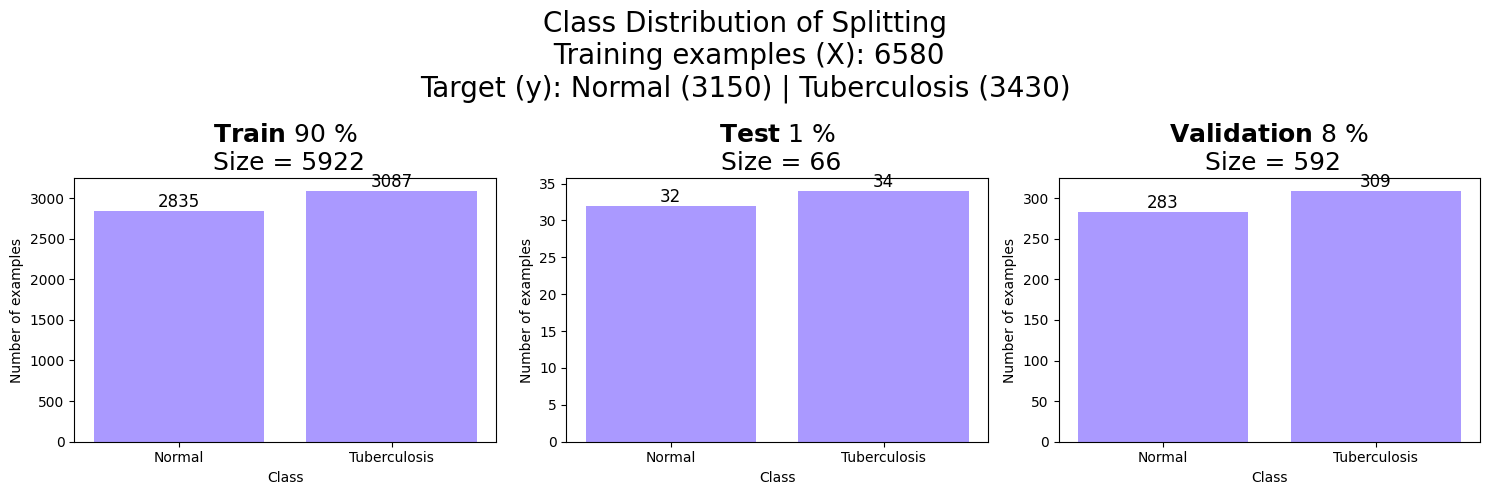

In [16]:
X_train, y_train, X_test, y_test, X_val, y_val = viz_class_distribution(X=X, 
                        y=y, 
                        title='Class Distribution of Splitting', 
                        classe_labels=['Normal', 'Tuberculosis'], 
                        train_percent=0.9, 
                        val_percent=0.09, 
                        test_percent=0.01)

# 4. Modeling

In [17]:
model_config = {
    # (height, width, channels)
    'input_shape': (128, 128, 3),
    'unit_size_rate': 0.05,
    'l1_lambda': None,
    'l2_lambda': None,

    'conv_padding': 'same',
    'conv_kernel_size': (3, 3),
    'conv_stride': 1,

    'pool_padding': 'same',
    'pool_kernel_size': (2, 2),
    'pool_stride': 2,
    
    'dropout': 0,
    'pooling_type': 'max'
}

# Build model
model_1st = CNN(**model_config).build_model()
model_1st.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 1)       28        
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 1)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 3)         30        
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 3)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 6)         168       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 6)        

In [18]:
import time

In [19]:
optimizer = tf.keras.optimizers.legacy.Adam()
optimizer_config= optimizer.get_config()
optimizer_config

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [50]:
from sklearn.model_selection import KFold

# Define the range of l1 lambda values
l2_lambdas = [0.001, 0.01, 0.1, 1, 10]

# Initialize a list to store the validation accuracies for each l1 lambda value
val_accuracies = []

# Perform cross-validation
for i in range(len(l2_lambdas)):
    model_config["l2_lambda"] = l2_lambdas[i]

    # Build model
    model = CNN(**model_config).build_model()

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics='accuracy')

    # # Perform k-fold cross-validation
    # kfold = KFold(n_splits=5, shuffle=True)
    # fold_val_accuracies = []
    # for train_index, val_index in kfold.split(X_train):
    #     X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    #     y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model on the current fold
    model.fit(X_train, y_train,
                epochs=10,
                batch_size=64,
                validation_data=(X_val, y_val),
                verbose=1)

    # Evaluate the model on the validation fold and store the accuracy
    _, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
    # fold_val_accuracies.append(val_accuracy)

    # Calculate the average validation accuracy for the current l1 lambda value
    # avg_val_accuracy = sum(fold_val_accuracies) / len(fold_val_accuracies)
    val_accuracies.append(val_accuracy)

# Find the index of the l1 lambda value with the highest validation accuracy
best_l2_lambda_index = val_accuracies.index(max(val_accuracies))
best_l2_lambda = l2_lambdas[best_l2_lambda_index]

best_l2_lambda


# best lamda_l1 is 0.001


Epoch 1/10
93/93 [==============================] - 5s 46ms/step - loss: 0.5587 - accuracy: 0.7080 - val_loss: 0.4454 - val_accuracy: 0.8784
Epoch 2/10
93/93 [==============================] - 4s 47ms/step - loss: 0.4027 - accuracy: 0.8686 - val_loss: 0.3592 - val_accuracy: 0.8885
Epoch 3/10
93/93 [==============================] - 4s 38ms/step - loss: 0.3673 - accuracy: 0.8723 - val_loss: 0.3377 - val_accuracy: 0.8936
Epoch 4/10
93/93 [==============================] - 4s 39ms/step - loss: 0.3531 - accuracy: 0.8728 - val_loss: 0.3254 - val_accuracy: 0.8936
Epoch 5/10
93/93 [==============================] - 4s 40ms/step - loss: 0.3446 - accuracy: 0.8732 - val_loss: 0.3170 - val_accuracy: 0.8936
Epoch 6/10
93/93 [==============================] - 4s 40ms/step - loss: 0.3392 - accuracy: 0.8730 - val_loss: 0.3112 - val_accuracy: 0.8936
Epoch 7/10
93/93 [==============================] - 4s 39ms/step - loss: 0.3348 - accuracy: 0.8737 - val_loss: 0.3070 - val_accuracy: 0.8936
Epoch 8/10
93

In [20]:
start_time = time.time()
# verbose is progress bar; verbose = 1 display, verbose = don't display 
verbose = 1
# Compile the model
# model_config["l1_lambda"] = 0.001

model_1st = CNN(**model_config).build_model()

model_1st.compile(loss='binary_crossentropy',
                   optimizer=optimizer,
                   metrics='accuracy')

# Train the model
history = model_1st.fit(X_train, y_train, 
                             epochs=30,
                             batch_size=64,
                             validation_data=(X_val, y_val),
                             verbose=verbose)

end_time = time.time()
training_time = end_time - start_time
training_time

Epoch 1/30
93/93 [==============================] - 4s 45ms/step - loss: 0.4876 - accuracy: 0.8023 - val_loss: 0.3560 - val_accuracy: 0.8446
Epoch 2/30
93/93 [==============================] - 4s 43ms/step - loss: 0.3003 - accuracy: 0.8745 - val_loss: 0.2833 - val_accuracy: 0.8784
Epoch 3/30
93/93 [==============================] - 4s 42ms/step - loss: 0.2515 - accuracy: 0.9021 - val_loss: 0.2549 - val_accuracy: 0.8885
Epoch 4/30
93/93 [==============================] - 4s 40ms/step - loss: 0.2214 - accuracy: 0.9139 - val_loss: 0.2490 - val_accuracy: 0.8970
Epoch 5/30
93/93 [==============================] - 4s 43ms/step - loss: 0.2182 - accuracy: 0.9193 - val_loss: 0.2136 - val_accuracy: 0.9122
Epoch 6/30
93/93 [==============================] - 4s 44ms/step - loss: 0.1970 - accuracy: 0.9227 - val_loss: 0.2254 - val_accuracy: 0.9054
Epoch 7/30
93/93 [==============================] - 4s 43ms/step - loss: 0.1751 - accuracy: 0.9338 - val_loss: 0.1845 - val_accuracy: 0.9240
Epoch 8/30
93

117.82464408874512

In [21]:
print(f'Training time in minutes: {training_time/60:.2f} minutes')

Training time in minutes: 1.96 minutes


In [22]:
get_config = {
            'Optimizer parameters Configuration': {
                'optimizer_name': optimizer_config['name'],
                'learning_rate': optimizer_config['learning_rate'],
                'beta1': optimizer_config['beta_1'],
                'beta2': optimizer_config['beta_2'],
                'epsilon': optimizer_config['epsilon'],
            },
            'Hyperparameters Configuration': {
                'conv_padding': model_config['conv_padding'],
                'conv_kernel_size': model_config['conv_kernel_size'],
                'conv_stride': model_config['conv_stride'],
                'pool_padding': model_config['pool_padding'],
                'pool_kernel_size': model_config['pool_kernel_size'],
                'pool_stride': model_config['pool_stride'],
                'pooling_type': model_config['pooling_type'],
            },
            'Model Architecture Configuration': {
                'input_shape': model_config['input_shape'],
                'unit_size_rate': model_config['unit_size_rate']
            },
            'Model Training Configuration': {
                'batch_size': 20,
                'epoch': 64
            },
        }
get_config

{'Optimizer parameters Configuration': {'optimizer_name': 'Adam',
  'learning_rate': 0.001,
  'beta1': 0.9,
  'beta2': 0.999,
  'epsilon': 1e-07},
 'Hyperparameters Configuration': {'conv_padding': 'same',
  'conv_kernel_size': (3, 3),
  'conv_stride': 1,
  'pool_padding': 'same',
  'pool_kernel_size': (2, 2),
  'pool_stride': 2,
  'pooling_type': 'max'},
 'Model Architecture Configuration': {'input_shape': (128, 128, 3),
  'unit_size_rate': 0.05},
 'Model Training Configuration': {'batch_size': 20, 'epoch': 64}}

In [23]:
def get_history(history,
                model,
                training_time:float, 
                ref_name:str, 
                title:str):

        best_epoch = np.argmax(history.history['val_accuracy'])
        best_train_epoch = np.argmax(history.history['accuracy'])

        # Create a 1x2 grid of subplots
        fig, axes = plt.subplots(1, 2, figsize=(24, 15))

        # Plot training and validation accuracy
        axes[0].plot(history.epoch, history.history['accuracy'],
                     label='Train Accuracy')
        axes[0].plot(history.epoch, history.history['val_accuracy'],
                     label='Validation Accuracy')
        axes[0].scatter(best_epoch, history.history['val_accuracy']
                        [best_epoch], color='r', label='Best Epoch (Validation)')
        axes[0].scatter(best_train_epoch, history.history['accuracy']
                        [best_train_epoch], color='g', label='Best Epoch (Train)')

        # Annotate the best validation accuracy point
        best_accuracy = history.history['val_accuracy'][best_epoch]
        random_offset_x = 10
        random_offset_y = np.random.randint(-30, 30)
        axes[0].annotate(f'{best_accuracy:.3f}',
                         xy=(best_epoch, best_accuracy),
                         xytext=(random_offset_x, random_offset_y),
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='->'))

        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy (%)')
        axes[0].set_title('Training and Validation Accuracy')
        axes[0].legend()

        # Annotate the best training accuracy point
        best_train_accuracy = history.history['accuracy'][best_train_epoch]
        random_offset_y = np.random.randint(-30, 30)
        axes[0].annotate(f'{best_train_accuracy:.3f}',
                         xy=(best_train_epoch, best_train_accuracy),
                         xytext=(random_offset_x, random_offset_y),
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='->'))

        # Plot training and validation loss
        axes[1].plot(history.epoch,
                    history.history['loss'], label='Train Loss')
        axes[1].plot(history.epoch, history.history['val_loss'],
                     label='Validation Loss')
        axes[1].scatter(best_epoch, history.history['val_loss']
                        [best_epoch], color='r', label='Best Epoch (Validation)')
        axes[1].scatter(best_train_epoch,history.history['loss']
                        [best_train_epoch], color='g', label='Best Epoch (Train)')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].set_title('Training and Validation Loss')
        axes[1].legend()

        # Annotate the best validation loss point
        best_loss = history.history['val_loss'][best_epoch]
        random_offset_y = np.random.randint(-30, 30)
        axes[1].annotate(f'{best_loss:.3f}',
                         xy=(best_epoch, best_loss),
                         xytext=(random_offset_x, random_offset_y),
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='->'))

        # Annotate the best training loss point
        best_train_loss = history.history['loss'][best_train_epoch]
        random_offset_y = np.random.randint(-30, 30)
        axes[1].annotate(f'{best_train_loss:.3f}',
                         xy=(best_train_epoch, best_train_loss),
                         xytext=(random_offset_x, random_offset_y),
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='->'))

        # Calculate best validation accuracy in percentage
        best_accuracy_percentage = round(best_accuracy * 100, 2)

        # String for performance, accuracy, and training time
        minutes = int(training_time // 60)
        seconds = int(training_time % 60)

        # model summary
        stringlist = []
        model.summary(print_fn=lambda x: stringlist.append(x))
        short_model_summary = "\n".join(stringlist)

        # Set the text for the parameters on the right side
        performance = r'$\bf{' + f'Ref. name: {ref_name}' + '}$' + f"\nBest Validation Accuracy: {best_accuracy_percentage}%" + \
            f"\nBest Train Accuracy: {history.history['accuracy'][best_train_epoch] * 100:.2f}%" + \
            f", Training Time: {minutes} minutes {seconds} seconds"
        fig.suptitle(r'$\bf{' + title + '}$' +
                     '\n' + performance, fontsize=18)

        fig.text(1.05, 1.00, r'$\bf{' + 'Config Parameters:' + '}$', fontsize=16,
                 color='black', ha='left', transform=plt.gcf().transFigure)

        y_coord = 0.98  # Initial y-coordinate

        # Set the line height between each parameter group and each parameter within a group
        line_height = 0.028

        for group, params in get_config.items():
            fig.text(1.05, y_coord, r'$\bf{' + f'{group}:' + '}$', fontsize=14,
                     color='black', ha='left', transform=plt.gcf().transFigure)
            y_coord -= line_height

            for key, value in params.items():
                fig.text(1.05, y_coord, f"{key}: {value}", fontsize=12,
                         color='black', ha='left', transform=plt.gcf().transFigure)
                y_coord -= line_height

        fig.text(1.05, 0.01, r'$\bf{' + f'Model Summary:' + '}$' + f'\n{short_model_summary}',
                 fontsize=10, color='black', ha='left', transform=plt.gcf().transFigure)

        plt.tight_layout()
        plt.show()

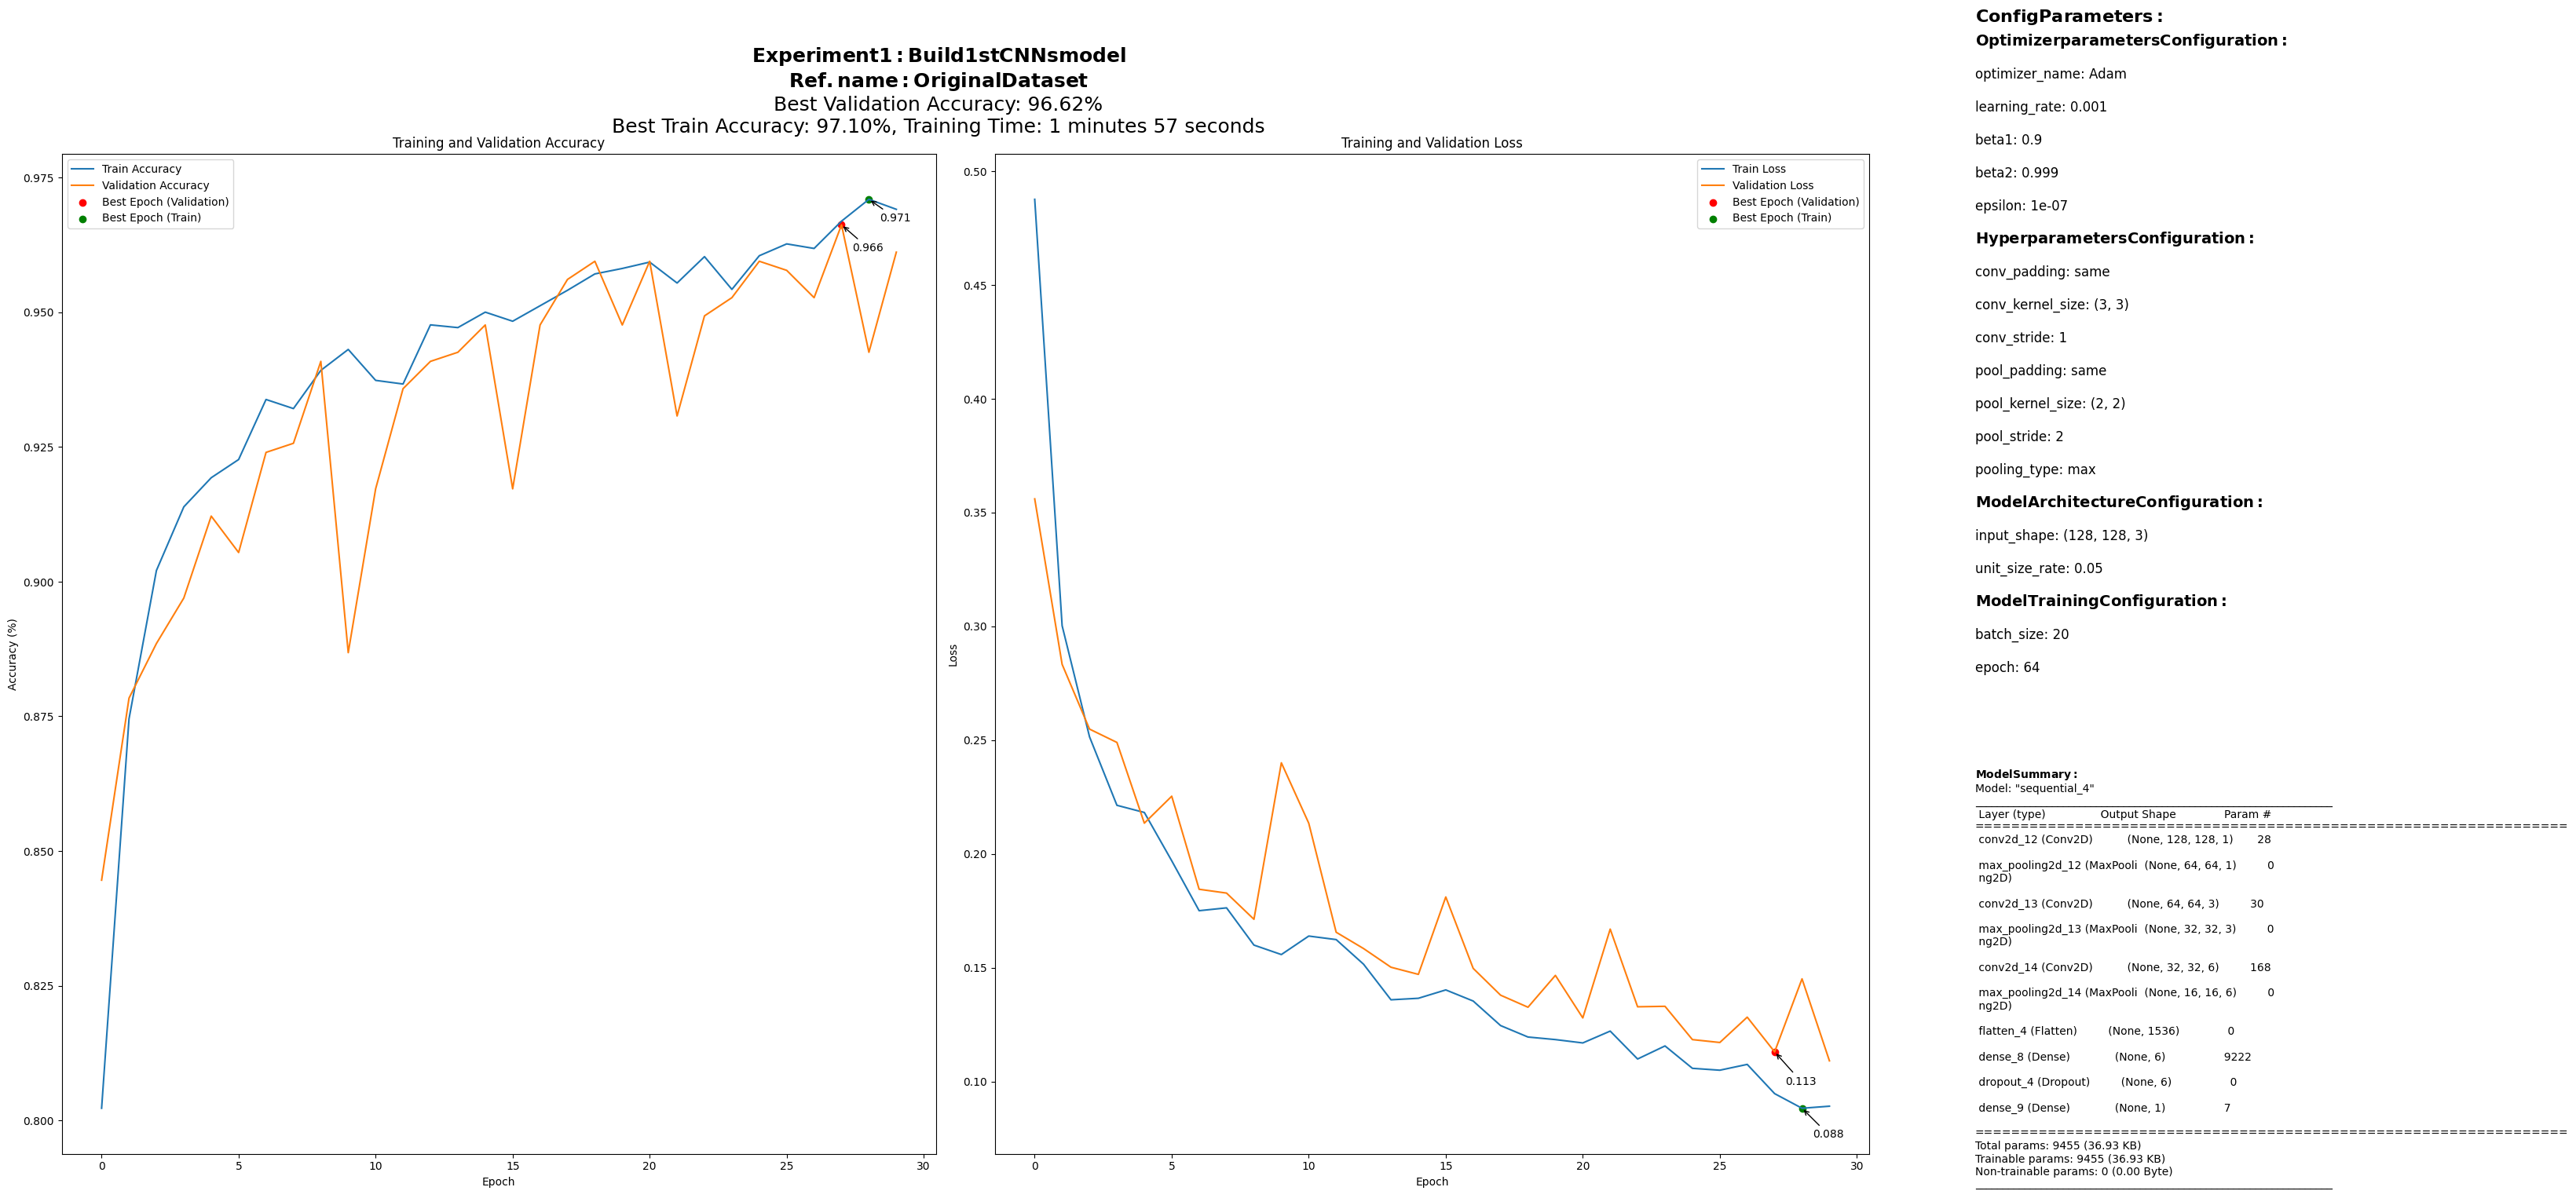

In [24]:
title = 'Experiment 1: Build 1st CNNs model'
get_history(history=history,
            model=model_1st,
            training_time=training_time, 
            title=title, 
            ref_name='Original Dataset')

# 5. Evaluation

In [25]:
import json
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score, f1_score

In [26]:
def evaluate(estimator_name, estimator, X, y_actual, subset_name, training_time, threshold=None):

        # Model Prediction/Y hat
        y_pred = estimator.predict(
            X) 
        # Handling Output Layer of Activation='sigmoid'
        threshold = threshold if threshold else 0.5
        y_pred_binary = (y_pred > threshold).astype(int).flatten()

        # Calculate ROC curve and AUC score
        fpr, tpr, thresholds = roc_curve(y_actual, y_pred_binary)
        auc_score = roc_auc_score(y_actual, y_pred_binary)
        # Classification Report
        report = classification_report(
            y_actual, y_pred_binary, output_dict=True)
        report_dict = json.loads(json.dumps(report))

        # Extract precision and recall from report_dict
        precision = report_dict['weighted avg']['precision']
        recall = report_dict['weighted avg']['recall']
        accuracy = report_dict['accuracy']
        f1 = report_dict['weighted avg']['f1-score']

        # Confusion Matrix
        cm = confusion_matrix(y_actual, y_pred_binary)
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]
        total_seconds = training_time
        minutes = int(training_time // 60)
        seconds = int(training_time % 60)
        training_time_ = "{} minutes {} seconds".format(minutes, seconds)

        accuracy_train = history.history['accuracy']
        accuracy_val = history.history['val_accuracy']

        performance_info = {
            'Model': estimator_name,
            'accuracy_train': accuracy_train,
            'accuracy_val': accuracy_val,
            'Subset': subset_name,
            'Training time': training_time_,
            'Training in seconds': total_seconds,
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'AUC': auc_score,
            'Accuracy': accuracy,
        }
        return pd.DataFrame([performance_info])

## 5.1 Training set Performance 

In [27]:
import pandas as pd

In [28]:
evaluate(estimator_name='CNN', 
         estimator=model_1st, 
         X=X_train, 
         y_actual=y_train, 
         subset_name='Training', 
         training_time=training_time
         )

186/186 [==============================] - 2s 9ms/step


,Model,accuracy_train,accuracy_val,Subset,Training time,Training in seconds,TP,FP,FN,TN,Precision,Recall,F1,AUC,Accuracy
0,CNN,"[0.8022627234458923, 0.8745356202125549, 0.902...","[0.8445945978164673, 0.8783783912658691, 0.888...",Training,1 minutes 57 seconds,117.824644,2739,96,48,3039,0.975792,0.975684,0.975674,0.975294,0.975684


## 5.2 Test set Performance 

In [29]:
evaluate(estimator_name='CNN', 
         estimator=model_1st, 
         X=X_test_noise_denoised, 
         y_actual=y_test_noise, 
         subset_name='Test', 
         training_time=1
         )

22/22 [==============================] - 0s 9ms/step


,Model,accuracy_train,accuracy_val,Subset,Training time,Training in seconds,TP,FP,FN,TN,Precision,Recall,F1,AUC,Accuracy
0,CNN,"[0.8022627234458923, 0.8745356202125549, 0.902...","[0.8445945978164673, 0.8783783912658691, 0.888...",Test,0 minutes 1 seconds,1,331,19,20,330,0.944289,0.944286,0.944286,0.944286,0.944286


In [30]:
def plot_confusion_matrix(y_actual, y_pred, subset_name):
    y_pred_binary = (y_pred > 0.5).astype(int).flatten()
    cm = confusion_matrix(y_actual, y_pred_binary)
    labels = ['Negative', 'Positive']

    # Extract TP, TN, FP, FN
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Sensitivity or True Positive Rate
    specificity = tn / (tn + fp)  # Specificity or True Negative Rate

    plt.figure(figsize=(18, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)



    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {subset_name}\n'
              f'True Positives: {tp} | True Negatives: {tn}\n'
              f'False Positives: {fp} (Type I error) | False Negatives: {fn} (Type II error)\n'
              f'Sensitivity (True Positive Rate): {sensitivity:.4f} | Specificity (True Negative Rate): {specificity:.4f}',
              loc='center', wrap=True)
    plt.show()

In [32]:
y_pred_test = model_1st.predict(X_test_noise_denoised)

22/22 [==============================] - 0s 10ms/step


## 5.3 Confusion matrix

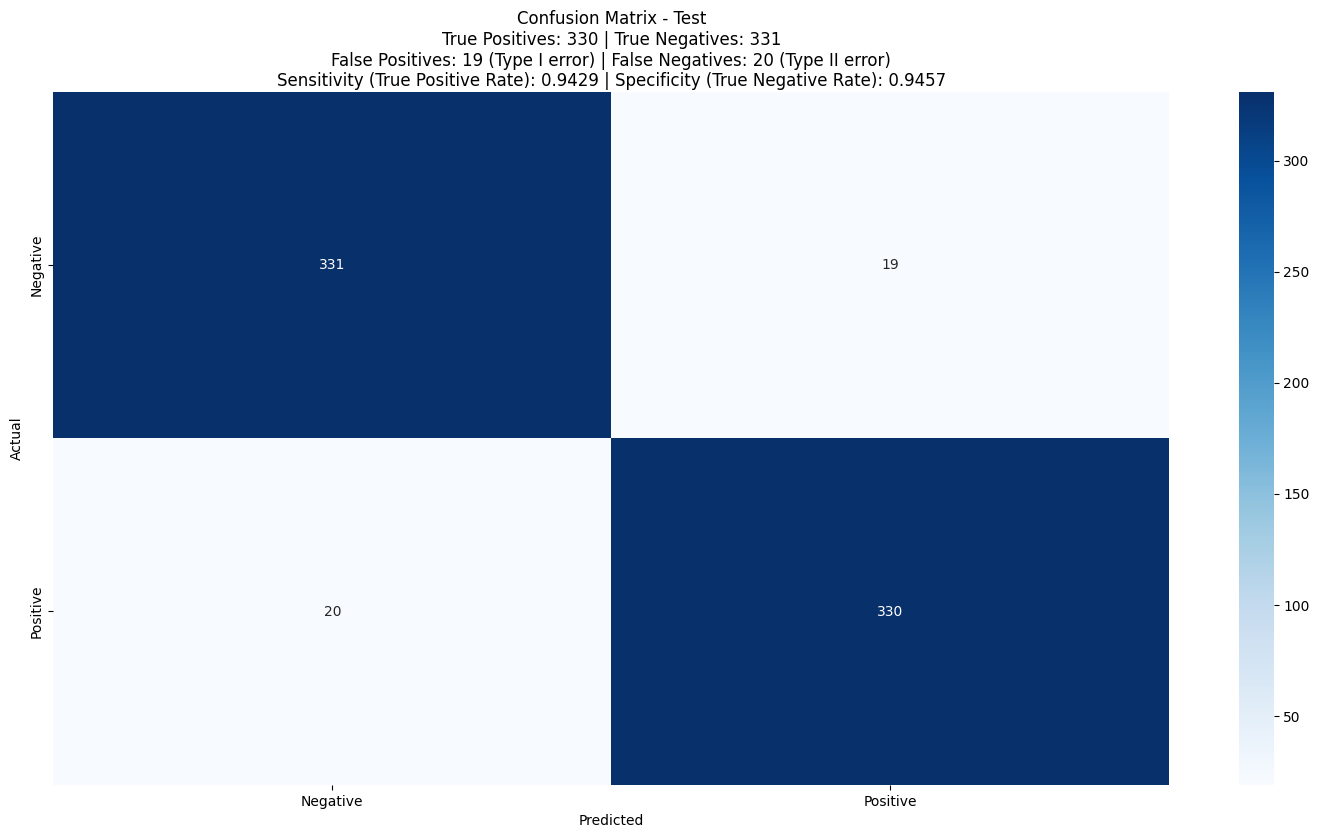

In [33]:
plot_confusion_matrix(y_actual=y_test_noise, 
                      y_pred=y_pred_test, 
                      subset_name='Test')

## 5.4 ROC

In [34]:
def plot_roc(y_actual, y_pred, subset_name):
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    # Print ROC Curve
    plt.figure(figsize=(18, 9))
    plt.plot(fpr, tpr, marker='o', linestyle='-',)
    plt.xlabel('False positive rate (1-Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')
    plt.title(f'ROC Curve - {subset_name}')
    plt.grid()
    plt.show()

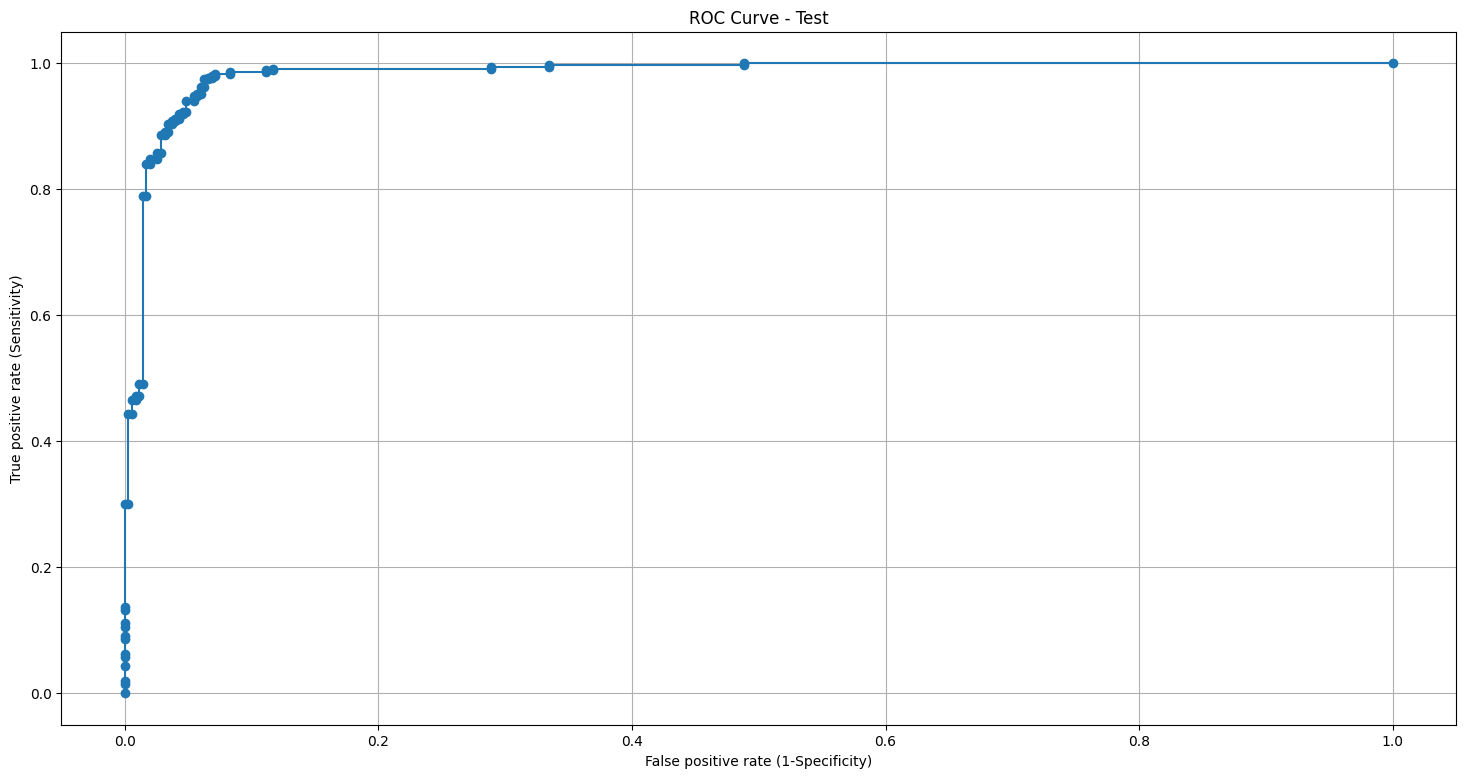

In [35]:
plot_roc(y_actual=y_test_noise, y_pred=y_pred_test, subset_name='Test')

# 6. Different Image Input Sizes
## **Expected Outcome:**

We expect that resizing the images to 128x128 might lead to a slight decrease in accuracy compared to using the original 512x512 images. However, the reduced image size may offer faster training and inference times, making it a more practical choice for resource-constrained environments. The experimental results will provide insights into the trade-offs between model accuracy and computational efficiency when dealing with different image sizes in TB detection using CNNs.

In [ ]:
target_shapes = [(16, 16),(32, 32), (64, 64), (128, 128)]
for target_shape in target_shapes:
    X_resized = tf.image.resize(X, target_shape).numpy()
    model_config = {
        # (height, width, channels)
        'input_shape': target_shape +(3,),
        'unit_size_rate': 0.05,
        'l1_lambda': None,
        'l2_lambda': None,

        'conv_padding': 'same',
        'conv_kernel_size': (3, 3),
        'conv_stride': 1,

        'pool_padding': 'same',
        'pool_kernel_size': (2, 2),
        'pool_stride': 2,

        'dropout': 0,
        'pooling_type': 'max'
    }

    # Build model
    model = CNN(**model_config)

    X_train, X_temp, y_train, y_temp = train_test_split(
    X_resized, y, test_size=0.2, random_state=42, stratify=y)

    X_test, X_val, y_test, y_val = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    # Train the model
    start_time = time.time()

    history = model.train(X_train, y_train, X_val, y_val,
                                 epochs=5,
                                 batch_size=64,
                                 verbose=0)
    end_time = time.time()
    training_time = end_time - start_time
    mean_acc = np.mean(history.history['val_accuracy'])
    show_image(images=X_resized, target=y,
               title=f'Resize the input images {target_shape}\nAvg. accuracy = {mean_acc:2f}\nTraining time: {training_time/60:.2f} minutes', 
               num_display=4, 
               num_cols=4, 
               random_mode=False)

# 7. Model Prediction

In [ ]:
def compare_actual_and_predicted_xray(estimator, images, target, title, num_display=16, num_cols=4, random_mode=False):
    '''
    Compare Actual X-ray Images with Model Predictions.

    Parameters:
        estimator: Model used for predictions.
        images (ndarray): Input data as a numpy array.
        target (ndarray): Target data as a numpy array.
        title (str): Title of the plot.
        num_display (int, optional): Number of images to display. Default is 16.
        num_cols (int, optional): Number of columns in the plot. Default is 4.
        random_mode (bool, optional): If True, display images randomly. If False, display the first num_display images. Default is False.

    Returns:
        None

    This function generates a visual comparison between actual X-ray images and their corresponding model predictions. It displays a grid of images with labels to show whether the model's predictions match the actual target values. The grid is organized in rows and columns based on the specified parameters.

    The function does not return any values; it displays the comparison plot directly.
    '''

    n_cols = min(num_cols, num_display)
    n_rows = int(np.ceil(num_display / n_cols))

    title = r'$\bf{' + "Actual-Image" + '}$' + " vs " + \
        r'$\bf{' + "Model-Prediction" + '}$'
    y_hat = estimator.predict(images)
    prediction = (y_hat > 0.5).astype(int).flatten()

    n_images = min(num_display, len(images))
    if random_mode:
        random_indices = np.random.choice(
            len(images), num_display, replace=False)
    else:
        random_indices = np.arange(num_display)

    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_cols, figsize=(20, 4*n_rows))
    for i, ax in enumerate(axes.flatten()):
        if i >= n_images:  # Check if the index exceeds the available number of images
            break
        # Incase (Did PCA)
        index = random_indices[i]
        if len(images.shape) == 2:
            image = images[index].reshape((128, 128)).astype(int)
        else:
            image = images[index]
        actual_label = target[index]
        model_pred_label = prediction[index]
        model_prob = '{:.3f}'.format(float(y_hat[index]))
        ax.imshow(
            image, cmap='gray' if actual_label == model_pred_label else 'OrRd')
        ax.set_title(
            f"Actual: {actual_label},\nModel Prediction: {model_pred_label}\nProbability: {model_prob}")
    plt.suptitle(f"{title} (Displaying {num_display} Images)",
                 fontsize=16, fontweight='bold')

    fig.set_facecolor('white')
    plt.tight_layout()  
    plt.show()

In [ ]:
compare_actual_and_predicted_xray(
                estimator=model_1st,
                images=X_test,
                target=y_test, 
                title=None,
                num_display=100,
                num_cols=10, 
                random_mode=True)

# 8. Lung segmentation
**Objective**: adapt this Lung segmentation for LIME
steps:
- Equalize the image with CLAHE
- Create a threshold mask to separate tissue by pixel intensity
- Find regions in the threshold
- Remove borders
- Fill small holes
- Extract lung areas

**Reference**: Lung Segmentation without CNN->https://www.kaggle.com/code/davidbroberts/lung-segmentation-without-cnn/notebook


In [ ]:
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border

In [ ]:
class ImageSegmentation:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def lung_segmentation(self, X):
        if X.shape != self.input_shape:
            X = X[:, :, 0]

        # Equalize the image with CLAHE
        X = exposure.equalize_adapthist(
            X, kernel_size=None, clip_limit=0.01, nbins=256)

        # Create a binary threshold mask and apply it to the image
        thresh = threshold_otsu(image=X, nbins=256, hist=None)
        thresh = X > thresh
        bw = closing(X > thresh, square(1))

        # Clean up the borders
        cleared = clear_border(bw)

        # Label image regions
        label_image = label(cleared)
        image_label_overlay = label2rgb(
            label_image,
            image=X,
            bg_label=0,
            bg_color=(0, 0, 0))

        return image_label_overlay, label_image

    def show_segmented_images(self,images, target, title, num_display=16, num_cols=4, cmap='gray', random_mode=False,only_segmented=True):
        '''
        :Parameters
            images (ndarray (n,)): Input data as a numpy array.
            target (ndarray (n,)): Target data as a numpy array.
            title (String): Title of the plot.
            num_display (int): Number of images to display. Default is 16.
            num_cols (int): Number of columns in the plot. Default is 4.
            cmap (str): Color map for displaying images. Default is 'gray'.
            random_mode (bool): If True, display images randomly. If False, display the first num_display images. Default is False.
        '''
        # Determine the number of rows based on the num_cols parameter
        n_cols = min(num_cols, num_display)
        n_rows = int(np.ceil(num_display / n_cols))

        n_images = min(num_display, len(images))
        if random_mode:
            random_indices = np.random.choice(
                len(images), num_display, replace=False)
        else:
            random_indices = np.arange(num_display)

        fig, axes = plt.subplots(
            nrows=n_rows, ncols=n_cols, figsize=(20, 4*n_rows))
        for i, ax in enumerate(axes.flatten()):
            if i >= n_images:  # Check if the index exceeds the available number of images
                break
            # Incase (Did PCA)
            index = random_indices[i]
            if len(images.shape) == 2:
                image = images[index].reshape((128, 128)).astype(int)
            else:
                image = images[index]

            image_label_overlay, label_image = self.lung_segmentation(
                image)
                
            ax.imshow(
                label_image if only_segmented else image_label_overlay, cmap=cmap)
            ax.set_title("Target: {}".format(target[index]))

            # Add image index as text
            ax.text(0.5, -0.15, f'Image Index: {index}', transform=ax.transAxes,
                    fontsize=10, ha='center')

        plt.suptitle(f"{title} (Displaying {num_display} Images)",
                    fontsize=16, fontweight='bold')

        fig.set_facecolor('white')
        plt.tight_layout()  # Added to ensure proper spacing between subplots
        return plt.show()


In [ ]:
img_segmetator=ImageSegmentation(input_shape=(128,128))

In [ ]:
img_segmetator.show_segmented_images(images=X,
                                     target=y,
                                     num_display=16, num_cols=8,
                                     title='Lung Segmentation',
                                     cmap='binary',
                                     random_mode=False,
                                     only_segmented=False)

In [ ]:
img_segmetator.show_segmented_images(images=X,
                                     target=y,
                                     num_display=16, num_cols=8,
                                     title='Lung Segmentation',
                                     cmap='binary',
                                     random_mode=False,
                                     only_segmented=True)

# 9. Explainability
## 9.1 Lime Library

**Local Interpretable Model-Agnostic Explanations (LIME)** 

is a library that explains predictions of machine learning models in an interpretable and understandable way. LIME works by training a local surrogate model around each prediction instance to approximate the behavior of the complex model. The surrogate model is then used to explain the prediction's outcome by highlighting the features that contributed the most to the decision.

**LIME**

is short for "Local Interpretable **Model-agnostic Explanations.**" It deals with explaining predictions made by **image-based** models, highlighting which areas of the input image were most influential in the model's decision-making process.

**Use to**

- **Interpretable** Literally translated, LIME is a method for translating the behavior of models that are difficult to understand so that normal people like us can understand them.

- **Model-Agnostic** This means that the LIME method can be used with any model, whether the model is a model that can read its behavior (such as linear regression, decision trees) or the model is so complex that we don't know its inner behavior (such as a neural network. ), which means we can view the model we use as a black-box.

- used to **explain why** a specific image was classified as it was by identifying the segmented areas (features) that had the most impact on the model's prediction.
- To **visualize** and **understand** Model's predictions

**Read more:** 
- Community: https://notebook.community/marcotcr/lime/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras
- Document: https://lime-ml.readthedocs.io/en/latest/lime.html
- How to Use LIME to Interpret Predictions of ML Models?: https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions

In [ ]:
# Lime
import lime
from lime.lime_image import LimeImageExplainer, ImageExplanation
# Ski
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
from skimage.transform import resize

import skimage.segmentation

# common
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import random

import cv2
import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu
from skimage.exposure import equalize_adapthist
from skimage.color import label2rgb
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import square, closing
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel
from skimage.color import rgb2gray

class Explainer():
    def __init__(self, estimator, input_shape=None, threshold=None):
        self.estimator = estimator
        self.input_shape = input_shape

    def lime(self, X, y, top_labels, num_samples, num_features, class_names, num_display, method='slic', random_mode=False, cmap='gray'):
        '''
        Explain and visualize model predictions using LIME (Local Interpretable Model-Agnostic Explanations).

        Parameters:
            X (ndarray): Input data as a numpy array.
            y (ndarray): Target data as a numpy array.
            top_labels (int): Top coefficients to show (e.g., 1 for binary classification).
            num_samples (int): Number of perturbations to generate.
            num_features (int): Number of highlighted features (segmented areas) to extract.
            model (object): Trained machine learning model.
            class_names (list): List of class names.
            num_display (int): Number of images to display.
            random_mode (bool, optional): If True, display images randomly. Default is False.
            cmap (str, optional): Colormap for displaying images. Default is 'gray'.

        Returns:
            None

        This function explains and visualizes model predictions using LIME. It generates explanations for model predictions and displays them along with various image representations.

        Note:
        - The `X` input should have a shape like (num_images, width, height, channels) (e.g., (100, 128, 128, 1)).
        - The `class_names` list should contain class labels.
        - The function displays the explanations and does not return any values.
        '''

        # Model prediction
        
        y_hat = self.estimator.predict(X)
        prediction = (y_hat > 0.5).astype(int).flatten()

        n_cols = 5  # Display 5 images in each row

        title = r'$\bf{' + "Actual-Image" + '}$' + " vs " + \
            r'$\bf{' + "Model-Prediction" + '}$'

        n_images = min(num_display, len(X))

        if random_mode:
            random_indices = np.random.choice(
                len(X), num_display, replace=False)
        else:
            random_indices = np.arange(num_display)

        for i, idx in enumerate(random_indices):
            
            X_resized = tf.image.resize(X[idx], self.input_shape).numpy()
#             # Change to RBG for input in Lime
#             rgb_resized_image = cv2.cvtColor(X_resized, cv2.COLOR_GRAY2RGB)
            rgb_resized_image = X_resized
            explainer = LimeImageExplainer()

            def model_pred_fn(images):
                y_hat = self.estimator.predict(images)
                return y_hat
            
            def segment_fn(image):
                if method == 'felzenszwalb':
                    segments = felzenszwalb(image, scale=200, sigma=0.5, min_size=50)
                elif method == 'slic':
                    segments = slic(image, n_segments=50, compactness=10, sigma=1)
                elif method == 'quickshift':
                    segments = quickshift(image, kernel_size=2, max_dist=50, ratio=0.5)
                elif method == 'watershed':
                    gradient = sobel(rgb2gray(image))
                    segments = watershed(gradient, markers=50, compactness=0.001)
                elif method == 'lung_segmentation':
                    segments = self.lung_segmentation(image)
                else:
                    raise ValueError(
                        "Invalid segmentation method. Supported methods: 'felzenszwalb', 'slic', 'quickshift', 'watershed', 'lung_segmentation'")

                return segments

            explanation = explainer.explain_instance(
                rgb_resized_image,
                model_pred_fn,
                top_labels=top_labels,
                hide_color=0,
                num_samples=num_samples,
                segmentation_fn=segment_fn,
            )
            #  positive_only=True if prediction[idx] ==0  else False,
            temp, mask = explanation.get_image_and_mask(
                explanation.top_labels[0],
                positive_only=False,
                num_features=num_features,
                hide_rest=False,
                min_weight=0.0
                )

            # Create a figure with 1 row and 5 columns
            fig, axes = plt.subplots(1, n_cols, figsize=(30, 6))

            # Add a big header title above the subplots
            plt.suptitle(
                title, fontsize=16)

            # First axis: Actual Image
            axes[0].imshow(X_resized, cmap=cmap) 
            actual_title = r'$\bf{' + 'Actual' + '}$'
            actual_cls = class_names[int(y[idx])]

            model_title = r'$\bf{' + 'Model-Prediction' + '}$'
            model_cls = class_names[int(prediction[idx])]
            model_prob = '{:.9f}'.format(float(y_hat[idx]))
            axes[0].set_title(actual_title + '\nTarget: ' + actual_cls)

            image_label_overlay = label2rgb(
                segment_fn(rgb_resized_image),
                image=rgb_resized_image,
                bg_label=0,
                bg_color=(0, 0, 0))

            axes[1].imshow(X_resized, cmap=cmap)
            axes[1].imshow(image_label_overlay)

            axes[1].set_title(model_title + '\nTarget: ' + model_cls)

            axes[2].imshow(segment_fn(rgb_resized_image),cmap='binary')
            axes[2].set_title(
                r'$\bf{' + 'Segmentation' + '}$' + f'\nProbability: ' + model_prob)
            
            # Third axis: Explanation Image
            axes[3].imshow(mark_boundaries(
                rgb_resized_image, segment_fn(rgb_resized_image)))
            axes[3].set_title(
                r'$\bf{' + 'LIME-Explanation' + '}$' + f'\nnumber of segments: {len(np.unique(segment_fn(rgb_resized_image)))}')
            temp, mask = explanation.get_image_and_mask(
                0,
                positive_only=True if prediction[idx] == 0 else False,
                num_features=num_features,
                hide_rest=False,
                min_weight=0.0
            )
            # Third axis: Explanation Image
            axes[4].imshow(mark_boundaries(
                temp, mask))
            axes[4].set_title(
                r'$\bf{' + 'LIME-Explanation' + '}$' + f'\nPositive and Negative regions')

            # Add the image index text
            plt.text(0.5, -0.15, f'Image Index: {idx}', transform=axes[0].transAxes,
                     fontsize=10, ha='center')

            plt.tight_layout()

            plt.show()

    def diff_sementation(self, X):
        # Generate a random sample index
        sample_index = random.randint(0, X.shape[0] - 1)

#         # Get the single grayscale sample
#         grayscale_sample = X[sample_index]

#         # Convert to RGB by repeating the single channel along the third axis
#         img = np.repeat(grayscale_sample, 3, axis=2)

        segments_fz = felzenszwalb(img, scale=200, sigma=0.5, min_size=50)
        segments_slic = slic(img, n_segments=50, compactness=10, sigma=1)
        segments_quick = quickshift(img, kernel_size=2, max_dist=50, ratio=0.5)
        gradient = sobel(rgb2gray(img))
        segments_watershed = watershed(gradient, markers=50, compactness=0.001)
        segments_equalize_adapthist = self.lung_segmentation(img)

        fig, ax = plt.subplots(1, 5, figsize=(30, 6))

        ax[0].imshow(mark_boundaries(img, segments_fz))
        ax[0].set_title("Felzenszwalbs's method")
        ax[0].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_fz))}", transform=ax[0].transAxes, ha='center')

        ax[1].imshow(mark_boundaries(img, segments_slic))
        ax[1].set_title('SLIC')
        ax[1].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_slic))}", transform=ax[1].transAxes, ha='center')

        ax[2].imshow(mark_boundaries(img, segments_quick))
        ax[2].set_title('Quickshift')
        ax[2].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_quick))}", transform=ax[2].transAxes, ha='center')

        ax[3].imshow(mark_boundaries(img, segments_watershed))
        ax[3].set_title('Compact watershed')
        ax[3].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_watershed))}", transform=ax[3].transAxes, ha='center')
        ax[4].imshow(mark_boundaries(img, segments_equalize_adapthist))
        ax[4].set_title('lung_segmentation')
        ax[4].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_equalize_adapthist))}", transform=ax[4].transAxes, ha='center')

        for a in ax.ravel():
            a.set_axis_off()

        plt.tight_layout()
        plt.show()

    def lung_segmentation(self, X):
        # Single of exmaple
        X = X[:, :, 0]

        # Even out the contrast with CLAHE
        X_equalized = equalize_adapthist(
            X, kernel_size=None, clip_limit=0.05, nbins=256)

        # Make a binary threshold mask and apply it to the image
        thresh = threshold_otsu(image=X_equalized, nbins=256, hist=None)
        thresh = X_equalized > thresh
        bw = closing(X_equalized > thresh, square(1))

        # Clean up the borders
        cleared = clear_border(bw)

        # Label image regions
        label_image = label(cleared)
        

        return label_image


In [ ]:
explnr = Explainer(estimator=model_1st, input_shape=(128, 128))

In [ ]:
explnr.diff_sementation(X=X_test)

In [ ]:
model_1st.summary()

In [ ]:
explnr.lime(X=X_test,
            y=y_test,
            top_labels=1,
            num_samples=1000,
            num_features=5,
            class_names=['Normal', 'Tuberculosis'],
            num_display=10,
            method='lung_segmentation',
            random_mode=True,
            cmap='gray'
            )


In [ ]:
explnr.lime(X=X_test,
            y=y_test,
            top_labels=1,
            num_samples=100,
            num_features=5,
            class_names=['Normal', 'Tuberculosis'],
            num_display=30,
            method='slic',
            random_mode=True,
            cmap='gray')